TensorFlow Version: 2.12.0
NumPy Version: 1.26.4

--- CONFIGURATION ---
Models will be saved in: ../saved_models

--- LOADING AND PREPARING DATA ---
Training samples: 7010
Validation samples: 1502
Test samples: 1503

Calculated Class Weights: {0: 0.21338772031292808, 1: 1.285530900421786, 2: 1.3022478172023035, 3: 2.7817460317460316, 4: 4.37305053025577, 5: 10.115440115440116, 6: 12.36331569664903}

--- BUILDING TF DATASET PIPELINE ---
Data pipelines created successfully.

--- BUILDING THE MODEL ---
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooli

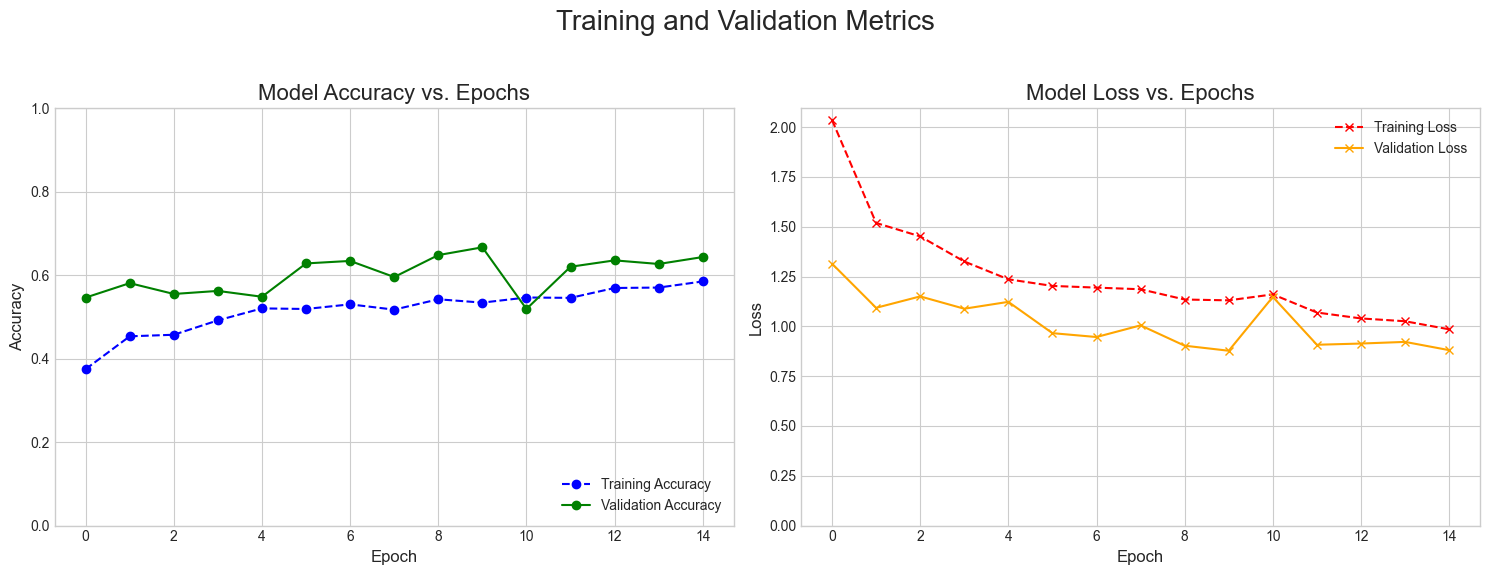

In [1]:
# ==============================================================================
#                      IMPORTS AND INITIAL SETUP
# ==============================================================================
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
print(f"TensorFlow Version: {tf.__version__}")
print(f"NumPy Version: {np.__version__}")


# ==============================================================================
#                             CONFIGURATION
# ==============================================================================
print("\n--- CONFIGURATION ---")
# --- Project Paths (assuming the notebook is in the 'notebooks' folder) ---
BASE_DIR = '../' 
DATA_DIR = os.path.join(BASE_DIR, 'data')
SAVED_MODELS_DIR = os.path.join(BASE_DIR, 'saved_models')

# --- Dataset Details ---
METADATA_PATH = os.path.join(DATA_DIR, 'HAM10000_metadata.csv')
IMAGE_DIR_PART1 = os.path.join(DATA_DIR, 'ham10000_images_part_1')
IMAGE_DIR_PART2 = os.path.join(DATA_DIR, 'ham10000_images_part_2')

# --- Model & Training Parameters ---
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30 # Start with fewer epochs (e.g., 15) for a faster initial run
LEARNING_RATE = 0.001

# --- Class Mapping ---
CLASSES = {
    'nv': 'Melanocytic nevi', 'mel': 'Melanoma', 'bkl': 'Benign keratosis-like lesions', 
    'bcc': 'Basal cell carcinoma', 'akiec': 'Actinic keratoses', 'vasc': 'Vascular lesions', 
    'df': 'Dermatofibroma'
}
CLASS_TO_INT = {label: i for i, label in enumerate(CLASSES.keys())}
NUM_CLASSES = len(CLASSES)

# Create the directory for saved models if it doesn't exist
os.makedirs(SAVED_MODELS_DIR, exist_ok=True)
print(f"Models will be saved in: {SAVED_MODELS_DIR}")


# ==============================================================================
#                         DATA LOADING AND PREPARATION
# ==============================================================================
print("\n--- LOADING AND PREPARING DATA ---")
# 1. Load metadata and create image paths
df = pd.read_csv(METADATA_PATH)
image_paths = {os.path.splitext(f)[0]: os.path.join(p, f)
               for p in [IMAGE_DIR_PART1, IMAGE_DIR_PART2]
               for f in os.listdir(p)}
df['image_path'] = df['image_id'].map(image_paths.get)
df = df.dropna(subset=['image_path']) # Ensure all entries have a valid image path

# 2. Encode labels
df['label'] = df['dx'].map(CLASS_TO_INT)

# 3. Split the data (70% train, 15% validation, 15% test)
X = df['image_path']
y = df['label']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# 4. Calculate class weights to handle imbalance (using only training data)
class_weights_array = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: w for i, w in enumerate(class_weights_array)}
print(f"\nCalculated Class Weights: {class_weights}")


# ==============================================================================
#                     TENSORFLOW DATASET PIPELINE
# ==============================================================================
print("\n--- BUILDING TF DATASET PIPELINE ---")
def parse_image(filepath, label):
    """Loads and preprocesses an image."""
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Use the preprocessing function specific to the chosen model (ResNet50)
    image = tf.keras.applications.resnet50.preprocess_input(image) 
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return image, label

def augment(image, label):
    """Applies data augmentation to an image."""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

AUTOTUNE = tf.data.AUTOTUNE

# Create the training dataset with augmentation
train_ds = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
train_ds = (
    train_ds
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .cache()  # Cache after initial processing for speed
    .shuffle(buffer_size=1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE) # Overlap data preprocessing and model execution
)

# Create the validation dataset (no augmentation)
val_ds = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
val_ds = (
    val_ds
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
print("Data pipelines created successfully.")


# ==============================================================================
#                             MODEL DEFINITION
# ==============================================================================
print("\n--- BUILDING THE MODEL ---")
def build_model():
    # Load ResNet50 as the base model, pre-trained on ImageNet
    base_model = tf.keras.applications.ResNet50(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False, # Exclude the final classification layer
        weights='imagenet'
    )
    # Freeze the layers of the base model so they are not trained
    base_model.trainable = False 

    # Create the custom classification head
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False) # Run the base model in inference mode
    x = tf.keras.layers.GlobalAveragePooling2D()(x) # Pool features to a vector
    x = tf.keras.layers.Dropout(0.5)(x) # Regularization
    x = tf.keras.layers.Dense(256, activation='relu')(x) # Intermediate dense layer
    x = tf.keras.layers.Dropout(0.5)(x) # More regularization
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x) # Final output layer
    
    model = tf.keras.Model(inputs, outputs)
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    return model

model = build_model()
model.summary()


# ==============================================================================
#                           MODEL TRAINING
# ==============================================================================
print("\n--- SETTING UP TRAINING ---")
# Define callbacks for efficient training and saving the best model
checkpoint_path = os.path.join(SAVED_MODELS_DIR, "best_model_single_cell.h5")

# 1. ModelCheckpoint: Saves the model only when 'val_accuracy' improves.
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1
)

# 2. EarlyStopping: Stops training if 'val_accuracy' doesn't improve for 5 epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1
)

# 3. ReduceLROnPlateau: Reduces learning rate if 'val_loss' plateaus.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, verbose=1
)

# Start the training process
print("\n--- STARTING TRAINING ---")
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=[model_checkpoint, early_stopping, reduce_lr]
)
print(f"\n--- TRAINING COMPLETE ---")
print(f"The best model has been saved to: {checkpoint_path}")


# ==============================================================================
#                       VISUALIZE TRAINING RESULTS
# ==============================================================================
print("\n--- VISUALIZING TRAINING HISTORY ---")
history_df = pd.DataFrame(history.history)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 6))

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy', color='blue', marker='o', linestyle='--')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy', color='green', marker='o', linestyle='-')
plt.title('Model Accuracy vs. Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.ylim(0, 1)

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss', color='red', marker='x', linestyle='--')
plt.plot(history_df['val_loss'], label='Validation Loss', color='orange', marker='x', linestyle='-')
plt.title('Model Loss vs. Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.ylim(bottom=0)

plt.suptitle('Training and Validation Metrics', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()